In [1]:
import warnings
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import time

start_time = time.time()

warnings.filterwarnings('ignore')

df = pd.read_csv('../db/out/wta_mean_pvp.csv')

In [2]:
# Symetraia
testp1 = df.filter(regex='_P1_VS$', axis=1)

testp2 = df.filter(regex='_P2_VS$', axis=1)


feats = list(zip(testp1.columns, testp2.columns))


for col_a, col_b in feats:
    df[col_a[:-5] + '_diff' + '_vs'] = df[col_a] - df[col_b]

df.drop(testp1.columns, axis=1, inplace=True)

df.drop(testp2.columns, axis=1, inplace=True)

non_numeric_columns = df.select_dtypes(['object']).columns

df = df.drop(non_numeric_columns, axis=1)

testp1 = df.filter(regex='_P1$', axis=1)

testp2 = df.filter(regex='_P2$', axis=1)

feats = list(zip(testp1.columns, testp2.columns))

for col_a, col_b in feats:
    df[col_a[:-3] + '_diff'] = df[col_a] - df[col_b]

df.drop(testp1.columns, axis=1, inplace=True)

df.drop(testp2.columns, axis=1, inplace=True)

In [3]:
non_numeric_columns = df.select_dtypes(['object']).columns

df_numeric_only = df.drop(non_numeric_columns, axis=1)

df = df_numeric_only

df = df.drop(['match_id'], axis=1)

df = df.fillna(df.median())


def normalize(dff):
    result = dff.copy()
    for feature_name in dff.columns:
        max_value = dff[feature_name].max()
        min_value = dff[feature_name].min()
        result[feature_name] = (
            dff[feature_name] - min_value) / (max_value - min_value)
    return result


df = normalize(df)
# df.info()
df = df.fillna(df.median())

In [4]:
from sklearn.model_selection import train_test_split

Y = pd.DataFrame(df['y'])
df = df.drop(['y'], axis=1)
X = df
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=45, stratify=Y)

In [5]:
# AdaBoost Basic parameters

from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()

result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))

basic_report = classification_report(y_test, y_pred, output_dict=True)


# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# cnf_matrix

# disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
# disp.plot()
# plt.show()

y_pred_proba = result.predict_proba(X_test)[::, 1]
fpr_basic, tpr_basic, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_basic = metrics.roc_auc_score(y_test, y_pred_proba)

              precision    recall  f1-score   support

         0.0       0.67      0.66      0.67      1769
         1.0       0.67      0.68      0.68      1807

    accuracy                           0.67      3576
   macro avg       0.67      0.67      0.67      3576
weighted avg       0.67      0.67      0.67      3576



Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Score: 0.6767349162668594
Best Hyperparameters: {'n_estimators': 50, 'learning_rate': 0.1}


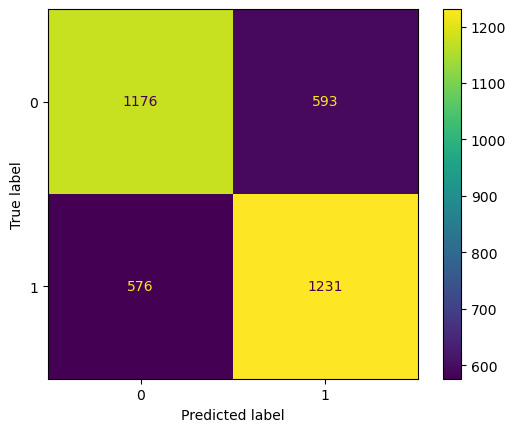

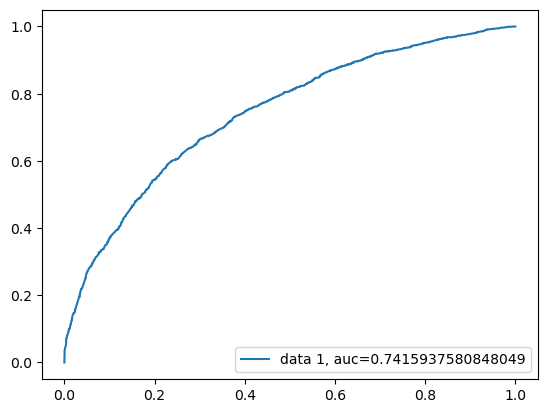

In [6]:
model = AdaBoostClassifier()

param_grid = {
    'n_estimators': list(range(20, 200, 10)),
    'learning_rate': list(np.arange(0.1, 1.1, 0.1)),
}

search = RandomizedSearchCV(model, param_grid, n_iter=10,
                            cv=10, scoring='accuracy', n_jobs=-1, random_state=45, verbose=2)

result = search.fit(X_train, y_train)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot()
plt.show()

y_pred_proba = result.predict_proba(X_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Optimal number of features : 7
                                   Rank
ace_probability_diff                  1
completeness_diff                     1
second_won_serve_diff                 1
rank_points_diff                      1
surface_wins_diff                     1
win_percentage_diff                   1
age_diff                              1
games_played_diff                     2
double_fault_probability__diff_vs     3
bp_factor_diff                        4
ace_probability__diff_vs              5
aceDf__diff_vs                        6
serve_points_won_diff                 7
first_serve_return_diff               8
aceDf_diff                            9
ht_diff                              10
elo_diff                             11
glicko_diff                          12
win_percentage__diff_vs              13
points_on_return_diff                14
first_won_serve_diff                 15
second_won_serve__diff_vs            16
total_serve_points_diff              17
df_probab

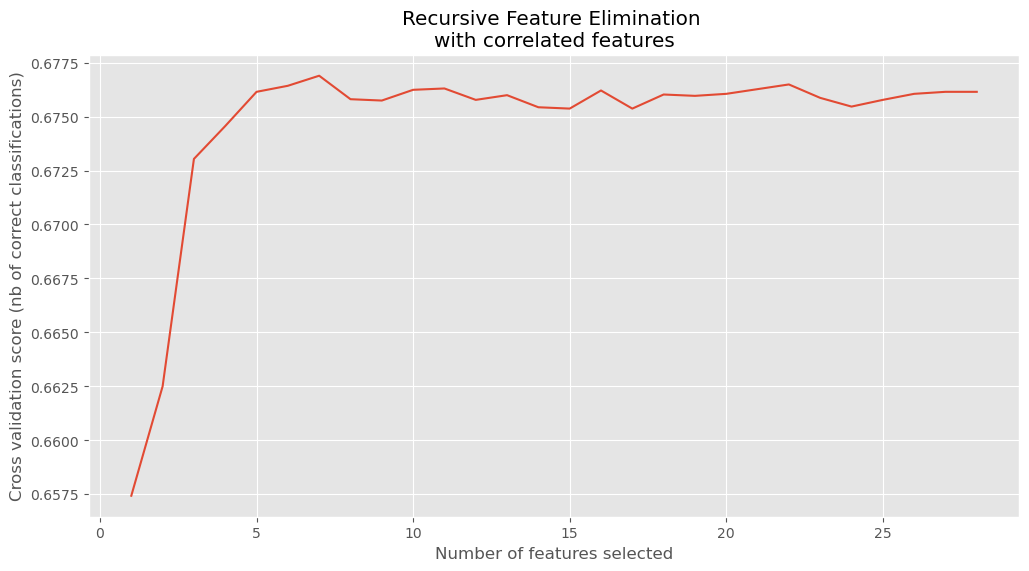

              precision    recall  f1-score   support

         0.0       0.67      0.68      0.68      1769
         1.0       0.68      0.68      0.68      1807

    accuracy                           0.68      3576
   macro avg       0.68      0.68      0.68      3576
weighted avg       0.68      0.68      0.68      3576



In [7]:
# AdaBoost with RFECV

model = AdaBoostClassifier(
    n_estimators=50, learning_rate=0.1, random_state=45, algorithm='SAMME.R')


cv = StratifiedKFold(3)

rfecv = RFECV(model, cv=cv, scoring='accuracy', step=1)

rfecv.fit(X_train, y_train)

y_pred = rfecv.predict(X_test)

print('Optimal number of features : %d' % rfecv.n_features_)

ranks = pd.DataFrame(
    rfecv.ranking_, index=X.columns, columns=['Rank'])

print(ranks.sort_values(by='Rank', ascending=True))

selected_features = ranks[ranks['Rank'] == 1].index.values.tolist()

# rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_, index=X.columns, columns=[
#                                       'Rank']).sort_values(by='Rank', ascending=True)
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
plt.plot(range(1, len(rfecv.cv_results_[
         "mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()


print(classification_report(y_test, y_pred))

# feat_importances = pd.DataFrame(
#     model.feature_importances_, index=X_test.columns, columns=["Importance"])
# feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
# feat_importances.plot(kind='bar', figsize=(8, 6))
# plt.show()


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix


disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot()
plt.grid(False)
plt.show()

y_pred_proba = result.predict_proba(X_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# plt.grid(True)
# plt.plot(fpr, tpr, label="data 1, auc="+str(auc), color='red')
# plt.plot(fpr_basic, tpr_basic, label="data 1, auc=" +
#          str(auc_basic), color='blue')
# plt.legend(loc=4)
# plt.show()

In [8]:
import json

filename = 'results.json'

final_results = {
    "report_basic": basic_report,
    "fpr_basic": fpr_basic.tolist(),
    "tpr_basic": tpr_basic.tolist(),
    "auc_basic": float(auc_basic),
    "report_optimized": classification_report(y_test, y_pred, output_dict=True),
    "fpr_optimized": fpr.tolist(),
    "tpr_optimized": tpr.tolist(),
    "auc_optimied": float(auc),
    "selected_features": selected_features,
    "time": time.time() - start_time
}


with open(filename, 'r') as file:
    data = json.load(file)


data['AdaBoost'] = (final_results)


with open('results.json', 'w') as file:
    json.dump(data, file, indent=4)